___
# Merge csv files for ETF shares, CME Open Interest, and CFTC COT reports.
___

In [41]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import os, sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)

import zipfile
import urllib.request
from PIL import Image
import jupyter_utilities as ju
import importlib
import pandasql as psql

# Make important folders
TEMP_FOLDER = './temp_folder'
try:
    os.mkdir(TEMP_FOLDER)
except:
    pass
SAVE_IMAGE_FOLDER = f'{TEMP_FOLDER}/gold'
try:
    os.mkdir(SAVE_IMAGE_FOLDER)
except:
    pass

def to_int(s):
    try:
        return int(float(str(s)))
    except:
        print(f'to_int exception on value:{s}')
        return None

pd.set_option('display.max_colwidth',1000)
    
cme_csv_save_folder = './cme_oi_data'
cot_data_path = './cot_history.csv'
etf_data_path = './etf_cap_hist.csv'

In [35]:
importlib.reload(ju)

<module 'jupyter_utilities' from '/Users/bperlman1/Documents/billybyte/pyliverisk/jupyter_notebooks/cme_open_interest/jupyter_utilities.py'>

### Define commodity and etf identifiers in the csv files

In [2]:
OI_ID_GOLD = 'GOLD FUTURES'
OI_ID_SILVER = 'SILVER FUTURES'
OI_ID_CL = 'CRUDE OIL LIGHT SWEET FUTURES'
OI_ID_10Y = '10Y NOTE FUTURE'
OI_ID_SPY = 'E-MINI S&P 500 FUTURE'
OI_ID_SOYB = 'SOYBEAN FUTURE'
OI_ID_WHEAT = 'WHEAT FUTURE'
OI_ID_COTTON = 'COTTON FUTURES'
OI_ID_EURO = 'EURO FX FUTURE'

COT_ID_GOLD= 'GOLD - COMMODITY EXCHANGE INC.'
COT_ID_SILVER= 'SILVER - COMMODITY EXCHANGE INC.'
# COT_ID_CL = 'CRUDE OIL, LIGHT SWEET'
COT_ID_CL = 'CRUDE OIL, LIGHT SWEET - NEW YORK MERCANTILE EXCHANGE'
COT_ID_10Y = '10-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE'
COT_ID_SPY = 'E-MINI S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE'
COT_ID_SOYB = 'SOYBEANS - CHICAGO BOARD OF TRADE'
COT_ID_WHEAT = 'WHEAT - CHICAGO BOARD OF TRADE'
COT_ID_EURO = 'EURO FX - CHICAGO MERCANTILE EXCHANGE'


ETF_ID_GOLD = 'GLD'
ETF_ID_SILVER = 'SLV'
ETF_ID_CL = 'USO'
ETF_ID_10Y = 'AGG'
ETF_ID_SPY = 'SPY'
ETF_ID_SOYB = 'SOYB'
ETF_ID_WHEAT = 'WEAT'
ETF_ID_EURO = 'FXE'


ETF_SHARES_DIVISOR_GOLD = 1000
ETF_SHARES_DIVISOR_SILVER = 5000
ETF_SHARES_DIVISOR_10Y = 1000
ETF_SHARES_DIVISOR_SPY = 500
ETF_SHARES_DIVISOR_SOYB = 5000
ETF_SHARES_DIVISOR_WHEAT = 5000
ETF_SHARES_DIVISOR_EURO = 1000
ETF_SHARES_DIVISOR_CL = 4000



ID_DICT = {
    'gold':{'OI':OI_ID_GOLD,'COT':COT_ID_GOLD,'ETF':ETF_ID_GOLD,'ETF_DIVISOR':ETF_SHARES_DIVISOR_GOLD},
    'silver':{'OI':OI_ID_SILVER,'COT':COT_ID_SILVER,'ETF':ETF_ID_SILVER,'ETF_DIVISOR':ETF_SHARES_DIVISOR_SILVER},
    '10Y':{'OI':OI_ID_10Y,'COT':COT_ID_10Y,'ETF':ETF_ID_10Y,'ETF_DIVISOR':ETF_SHARES_DIVISOR_10Y},
    'spy':{'OI':OI_ID_SPY,'COT':COT_ID_SPY,'ETF':ETF_ID_SPY,'ETF_DIVISOR':ETF_SHARES_DIVISOR_SPY},
    'soyb':{'OI':OI_ID_SOYB,'COT':COT_ID_SOYB,'ETF':ETF_ID_SOYB,'ETF_DIVISOR':ETF_SHARES_DIVISOR_SOYB},
    'wheat':{'OI':OI_ID_WHEAT,'COT':COT_ID_WHEAT,'ETF':ETF_ID_WHEAT,'ETF_DIVISOR':ETF_SHARES_DIVISOR_WHEAT},
    'euro':{'OI':OI_ID_EURO,'COT':COT_ID_EURO,'ETF':ETF_ID_EURO,'ETF_DIVISOR':ETF_SHARES_DIVISOR_EURO},
    'cl':{'OI':OI_ID_CL,'COT':COT_ID_CL,'ETF':ETF_ID_CL,'ETF_DIVISOR':ETF_SHARES_DIVISOR_CL},
}


___
### Get cme open interest, COT and ETF data from csv files
___

In [4]:
# df_soyb = fetch_history(ETF_ID_SOYB,df_etf.date.min(),df_etf.date.max())
# print(df_etf.tail())
# print(df_soyb.tail())
# df_etf = df_etf.append(df_soyb,ignore_index=True)

In [5]:
df_oi = None
years = np.linspace(2013,2019,7,dtype=int)
df_oi = None
for y in years:
    df_temp = pd.read_csv(f'{cme_csv_save_folder}/cme_open_interest_{y}.csv')
    df_temp = df_temp[~df_temp.Open_Interest.isnull()]
    if df_oi is None:
        df_oi = df_temp.copy()
    else:
        df_oi = df_oi.append(df_temp,ignore_index=True)
        df_oi.index = list(range(len(df_oi)))
df_oi.Open_Interest = df_oi.Open_Interest.apply(to_int)
df_oi.Total_Volume = df_oi.Total_Volume.apply(to_int)
df_oi = df_oi[~df_oi.Total_Volume.isnull()]
print(f'oi length:{len(df_oi)}')
df_etf = pd.read_csv(etf_data_path)
df_etf['trade_date'] = df_etf.date.apply(ju.str_to_yyyymmdd)
print(f'etf length:{len(df_etf)}')
df_cot2 = pd.read_csv(cot_data_path)
df_cot2.As_of_Date_in_Form_YYYY_MM_DD = df_cot2.As_of_Date_in_Form_YYYY_MM_DD.apply(ju.str_to_date)
df_cot2.Market_and_Exchange_Names = df_cot2.Market_and_Exchange_Names.str.strip() 
print(f'cot length:{len(df_cot2)}')


/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



to_int exception on value:**Total
Volume
to_int exception on value:ExPit
Volume
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on value:nan
to_int exception on 

In [6]:
df_etf.tail()

,symbol,date,nav,shares,trade_date
55627,FXF,2019-03-04,93.129997,0.0,20190304
55628,FXF,2019-03-05,92.669998,0.0,20190305
55629,FXF,2019-03-06,92.620003,0.0,20190306
55630,FXF,2019-03-07,91.989998,0.0,20190307
55631,FXF,2019-03-08,92.339996,0.0,20190308


### For some of the ETF's, get the data from yahoo, and ignore the shares data

In [7]:
def fetch_history(symbol,dt_beg,dt_end):
    df = pdr.DataReader(symbol, 'yahoo', dt_beg, dt_end)
    df['date'] = df.index
    df.date = df.date.apply(lambda d: str(d)[0:4] + "-" + str(d)[5:7] + "-" + str(d)[8:10])
    df['trade_date'] = df.date.apply(lambda d: int(str(d)[0:4] + str(d)[5:7] + str(d)[8:10]))
    df = df.sort_values('date')
    df.index = list(range(len(df)))
    # make adj close the close
    df['nav'] = df['Adj Close']
    df['symbol'] = symbol
    df['shares'] = 0
    df = df[['symbol','date','nav','shares','trade_date']]
    return df

    

### Find identifier strings for specific Open Interest and COT rows in their respective DataFrames
1. Enter values for oi_key_word, cot_key_word and etf_key_word below
2. Choose the product/market_and_exchange_name/symbol that has the highest open_interest or volume

In [8]:
import pdb
def create_merged_df(commod_to_use):
    global df_oi,df_etf,df_cot2
    # step 1 set up ID's
    OI_ID = ID_DICT[commod_to_use]['OI']
    COT_ID = ID_DICT[commod_to_use]['COT']
    ETF_ID = ID_DICT[commod_to_use]['ETF']
    ETF_DIVISOR = ID_DICT[commod_to_use]['ETF_DIVISOR']
    #Step 2: make sure ID's produce only one contract
    oi_key_word = OI_ID.lower()
    cot_key_word = COT_ID.lower()
    etf_key_word = ETF_ID.lower()

    l = (list(filter(lambda s: oi_key_word == str(s).lower(),df_oi.Product_Description.unique())))
    df_oi_sub = df_oi[df_oi.Product_Description.isin(l)][['Product_Description','Open_Interest']]
    df_oi_gb = df_oi_sub.groupby('Product_Description',as_index=False).sum()

    l = (list(filter(lambda s: cot_key_word == str(s).lower(),df_cot2.Market_and_Exchange_Names.unique())))
    df_cot_sub = df_cot2[df_cot2.Market_and_Exchange_Names.isin(l)][['Market_and_Exchange_Names','Open_Interest_All']]
    df_cot_gb = df_cot_sub.groupby('Market_and_Exchange_Names',as_index=False).sum()

    l = (list(filter(lambda s: etf_key_word == str(s).lower(),df_etf.symbol.unique())))
    if len(l) > 0:
        df_etf_sub = df_etf[df_etf.symbol.isin(l)][['symbol','shares']]
    else:
        # fetch from yahoo
        df_etf_sub = fetch_history(ETF_ID,df_etf.date.min(),df_etf.date.max())
        df_etf_sub.date
        df_etf = df_etf.append(df_etf_sub,ignore_index=True)        
    df_etf_gb = df_etf_sub.groupby('symbol',as_index=False).sum()

    if len(df_oi_gb) + len(df_cot_gb) + len(df_etf_gb) == 3:
        print(f"all ID's for commodity: {commod_to_use} are OK")
    else:
        print(f"!!!!! ALL ID's FOR COMMODITY: {commod_to_use} ARE NOT OK!!!!!!")
        print(f'oi is OK: {len(df_oi_gb)==1}')
        print(f'cot is OK: {len(df_cot_gb)==1}')
        print(f'etf is OK: {len(df_etf_gb)==1}')
        raise ValueError(f'ambiguous ID name {OI_ID}')
    
    
    # Step 3: merge oi, cot and etf stuff
    df_oi_single = df_oi[df_oi.Product_Description == OI_ID][['trade_date','Open_Interest','Total_Volume']]
    df_oi_single.Open_Interest = df_oi_single.Open_Interest.apply(to_int)
    df_oi_single.Total_Volume = df_oi_single.Total_Volume.astype(float).astype(int)
    df_etf_single = df_etf[df_etf.symbol==ETF_ID]

    df_cot_single = df_cot2[df_cot2.Market_and_Exchange_Names==COT_ID]
    basic_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD','Open_Interest_All']
    long_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD',
                'Noncommercial_Positions_Long_All','Commercial_Positions_Long_All',
                'Nonreportable_Positions_Long_All','Traders_Commercial_Long_All',
                 'Traders_Noncommercial_Long_All','Traders_Total_Reportable_Long_All']
    short_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD',
                'Noncommercial_Positions_Short_All','Commercial_Positions_Short_All',
                'Nonreportable_Positions_Short_All','Total_Reportable_Positions_Short_All',
                'Traders_Commercial_Short_All','Traders_Noncommercial_Short_All',
                'Traders_Total_Reportable_Short_All']
    df_commod_long = df_cot_single[long_cols]
    df_commod_short = df_cot_single[short_cols]

    def non_comm_net(r):
        return float(r.Noncommercial_Positions_Long_All) - float(r.Noncommercial_Positions_Short_All)
    def comm_net(r):
        return float(r.Commercial_Positions_Long_All) - float(r.Commercial_Positions_Short_All)
    def non_report_net(r):
        return float(r.Nonreportable_Positions_Long_All) - float(r.Nonreportable_Positions_Short_All)
    def traders_comm_net(r):
        return float(r.Traders_Commercial_Long_All) - float(r.Traders_Commercial_Short_All)
    def traders_noncomm_net(r):
        return float(r.Traders_Noncommercial_Long_All) - float(r.Traders_Noncommercial_Short_All)

    df_commod_net = df_commod_long.merge(df_commod_short,how='inner',on=['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD'])
    df_commod_net['Noncommercial_Positions_Net_All'] = df_commod_net.apply(non_comm_net,axis=1)
    df_commod_net['Commercial_Positions_Net_All'] = df_commod_net.apply(comm_net,axis=1)
    df_commod_net['Nonreportable_Positions_Net_All'] = df_commod_net.apply(non_report_net,axis=1)
    df_commod_net['Traders_Commercial_Net_All'] = df_commod_net.apply(traders_comm_net,axis=1)
    df_commod_net['Traders_Noncommercial_Net_All'] = df_commod_net.apply(traders_noncomm_net,axis=1)
    net_cols = ['Market_and_Exchange_Names','As_of_Date_in_Form_YYYY_MM_DD','Noncommercial_Positions_Net_All','Commercial_Positions_Net_All','Nonreportable_Positions_Net_All','Traders_Commercial_Net_All','Traders_Noncommercial_Net_All']
    df_commod_net = df_commod_net[net_cols]
    df_commod_net['cot_yyyymmdd'] = df_commod_net.As_of_Date_in_Form_YYYY_MM_DD.apply(ju.str_to_yyyymmdd)
    df_commod_net = df_commod_net.sort_values('cot_yyyymmdd')
    df_commod_net.index = list(range(len(df_commod_net)))

    last_date = ju.str_to_date(str(df_commod_net.iloc[-1].cot_yyyymmdd),sep='') + datetime.timedelta(7)
    last_date_yyyymmdd = ju.str_to_yyyymmdd(last_date)
    df_commod_net['next_cot_yyyymmdd'] = list(df_commod_net[1:].cot_yyyymmdd) + [last_date_yyyymmdd]
    cols_to_change = {'Noncommercial_Positions_Net_All':'noncomm','Commercial_Positions_Net_All':'comm',
                      'Nonreportable_Positions_Net_All':'nonrep','Traders_Commercial_Net_All':'trade_com',
                     'Traders_Noncommercial_Net_All':'trade_noncomm'}
    df_commod_net = df_commod_net.rename(columns=cols_to_change)

    df_etf_oi = df_etf_single[['trade_date','nav','shares']].merge(df_oi_single,how='inner',on='trade_date')
    df_etf_oi['nav_diff'] = df_etf_oi.nav.pct_change()
    df_etf_oi['share_diff'] = df_etf_oi.shares.pct_change()
    df_etf_oi['oi_diff'] = df_etf_oi.Open_Interest.pct_change()
    q = f"select * from df_etf_oi inner join df_commod_net on df_etf_oi.trade_date >= df_commod_net.cot_yyyymmdd and df_etf_oi.trade_date < df_commod_net.next_cot_yyyymmdd"
    df_etf_oi_cot =  psql.sqldf(q, locals())
    
    etf_oi_cols = list(df_etf_oi.columns.values)
    cot_cols = list(cols_to_change.values()) + ['cot_yyyymmdd','next_cot_yyyymmdd']
    etf_oi_cot_cols = etf_oi_cols + cot_cols
    df_etf_oi_cot = df_etf_oi_cot[etf_oi_cot_cols]

    # step 4: create final
    df_final = df_etf_oi_cot[['trade_date','nav','noncomm']][-1000:]
    df_final = df_final.loc[:,~df_final.columns.duplicated()]
    return df_final


### Create multi plot of all data commodities

In [9]:
dict_df = {}
last_n_days = 1000
for k in ID_DICT.keys():
    print(f'processing {k}')
    df = create_merged_df(k)
    dict_df[k] = df.iloc[-last_n_days:]


processing gold
all ID's for commodity: gold are OK
processing silver
all ID's for commodity: silver are OK
processing 10Y
all ID's for commodity: 10Y are OK
processing spy
all ID's for commodity: spy are OK
processing soyb
all ID's for commodity: soyb are OK
processing wheat
all ID's for commodity: wheat are OK
processing euro
all ID's for commodity: euro are OK
processing cl
all ID's for commodity: cl are OK


In [10]:
df_etf.date.unique()

array(['2003-09-22', '2003-09-23', '2003-09-24', ..., '2012-10-29',
       '2012-10-30', '2014-04-18'], dtype=object)

In [29]:
print(dict_df.keys())
dict_df['gold'].tail()

dict_keys(['gold', 'silver', '10Y', 'spy', 'soyb', 'wheat', 'euro', 'cl'])


,trade_date,nav,noncomm
1356,20190304,121.429623,135696.0
1357,20190305,121.277088,88018.0
1358,20190306,121.469489,88018.0
1359,20190307,121.416183,88018.0
1360,20190308,122.496907,88018.0


In [42]:
iplot(ju.plotly_pandas(dict_df['gold'],x_column='trade_date'))

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/plotly/matplotlylib/renderer.py:390: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/plotly/matplotlylib/renderer.py:487: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



([<matplotlib.axes._subplots.AxesSubplot at 0x127153438>,
 ['./temp_folder/saved_images/cot_nav_plot_gold1.png',
  './temp_folder/saved_images/cot_nav_plot_silver2.png',
  './temp_folder/saved_images/cot_nav_plot_10Y3.png',
  './temp_folder/saved_images/cot_nav_plot_spy4.png',
  './temp_folder/saved_images/cot_nav_plot_soyb5.png',
  './temp_folder/saved_images/cot_nav_plot_wheat6.png',
  './temp_folder/saved_images/cot_nav_plot_euro7.png',
  './temp_folder/saved_images/cot_nav_plot_cl8.png'])

<Figure size 432x288 with 0 Axes>

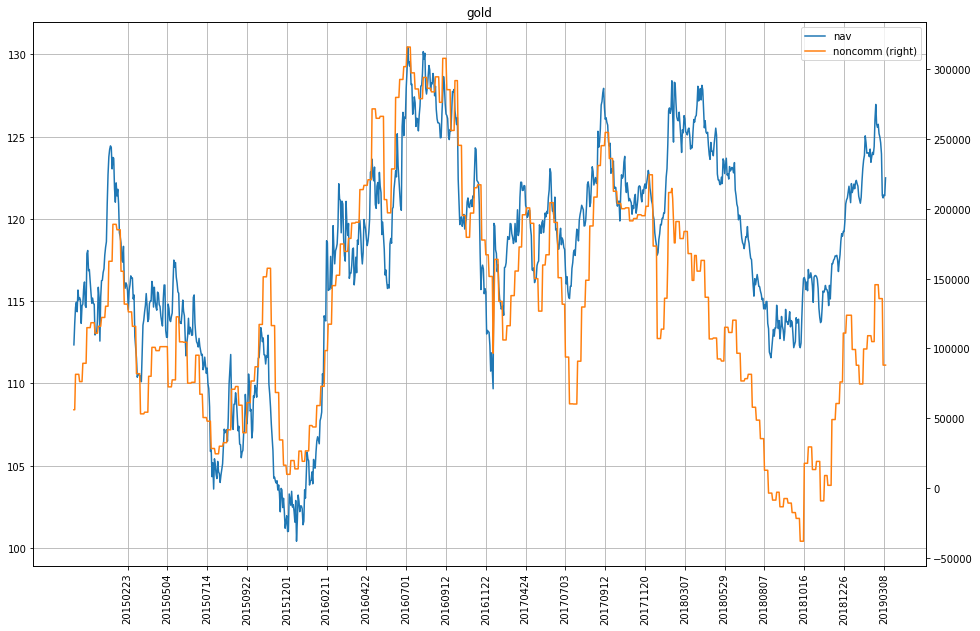

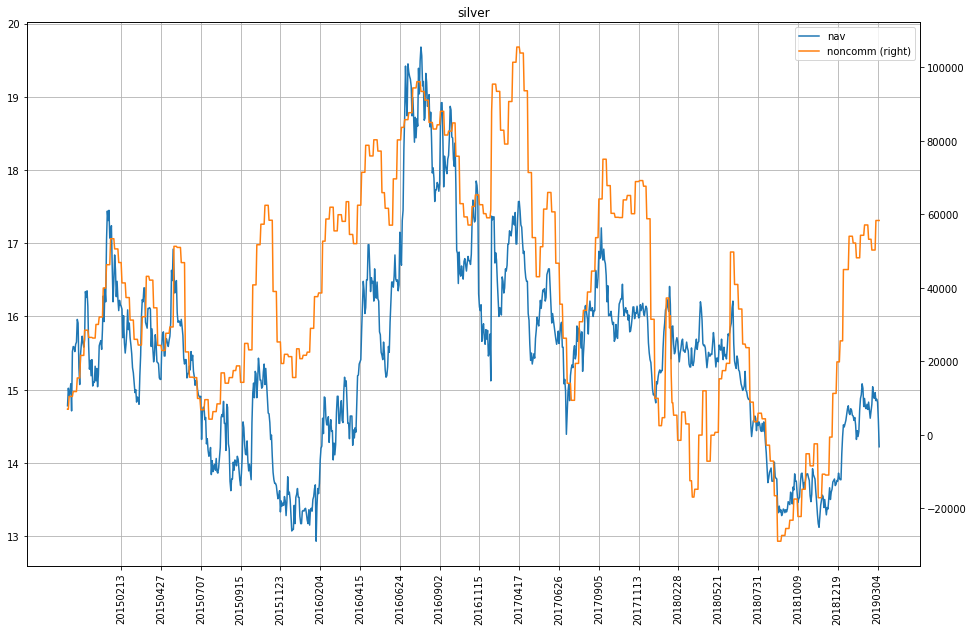

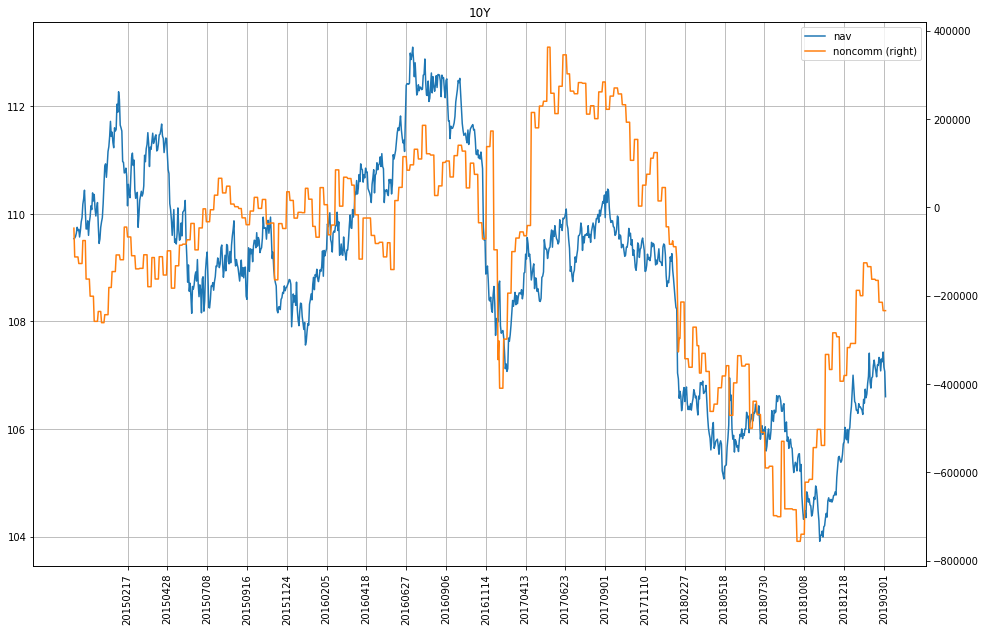

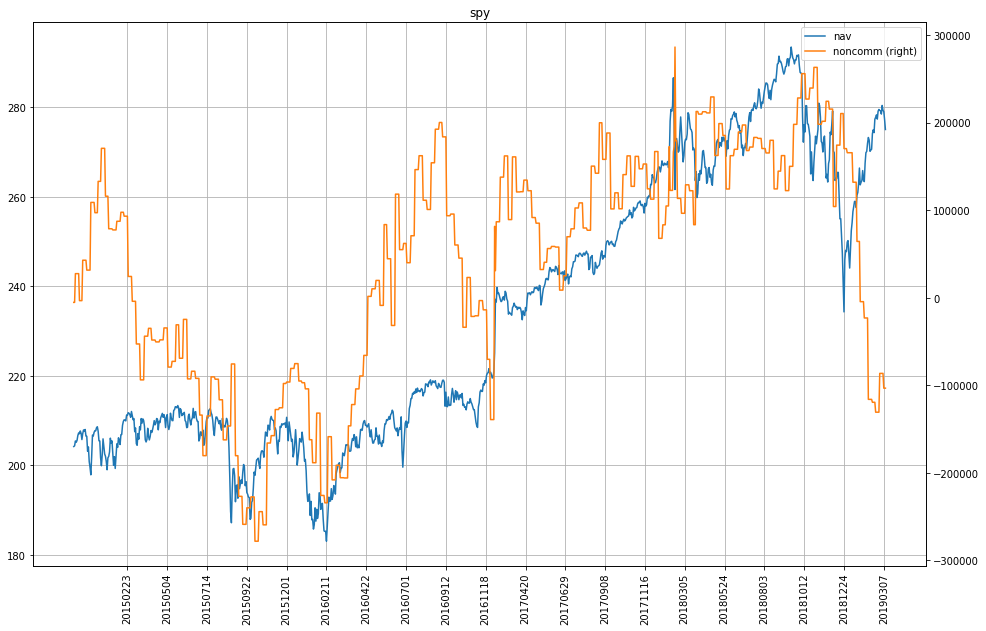

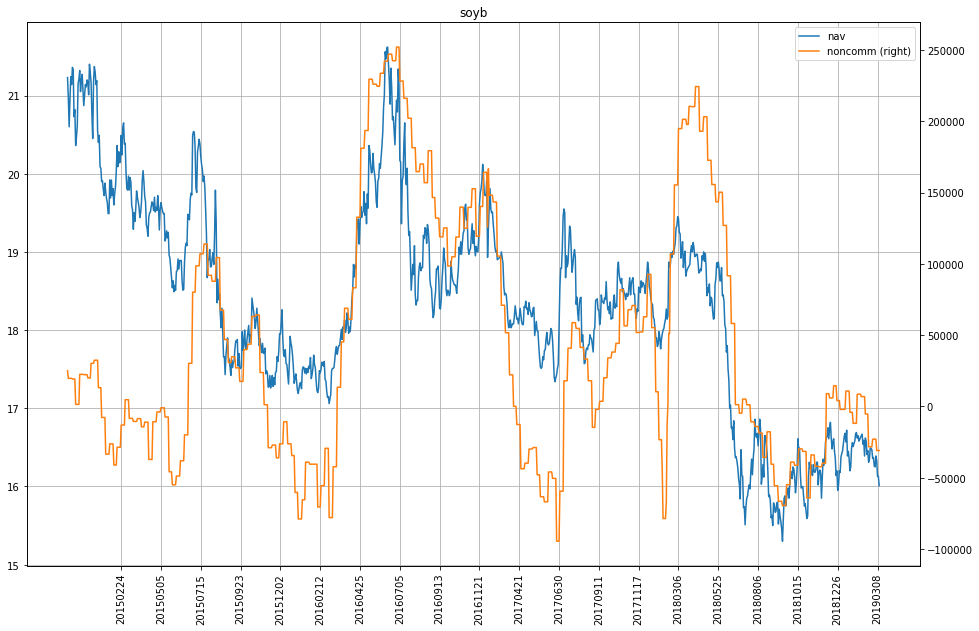

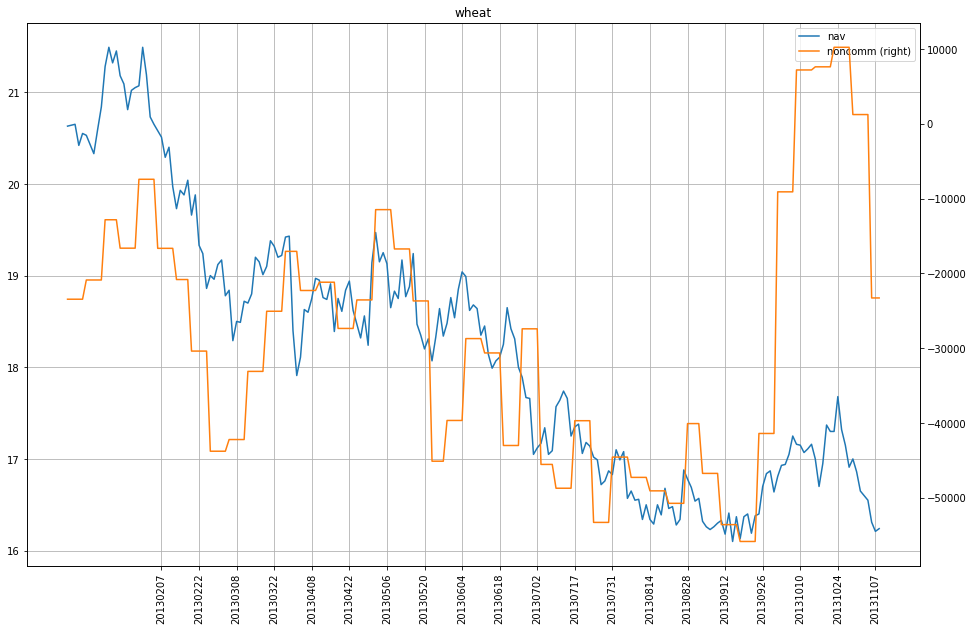

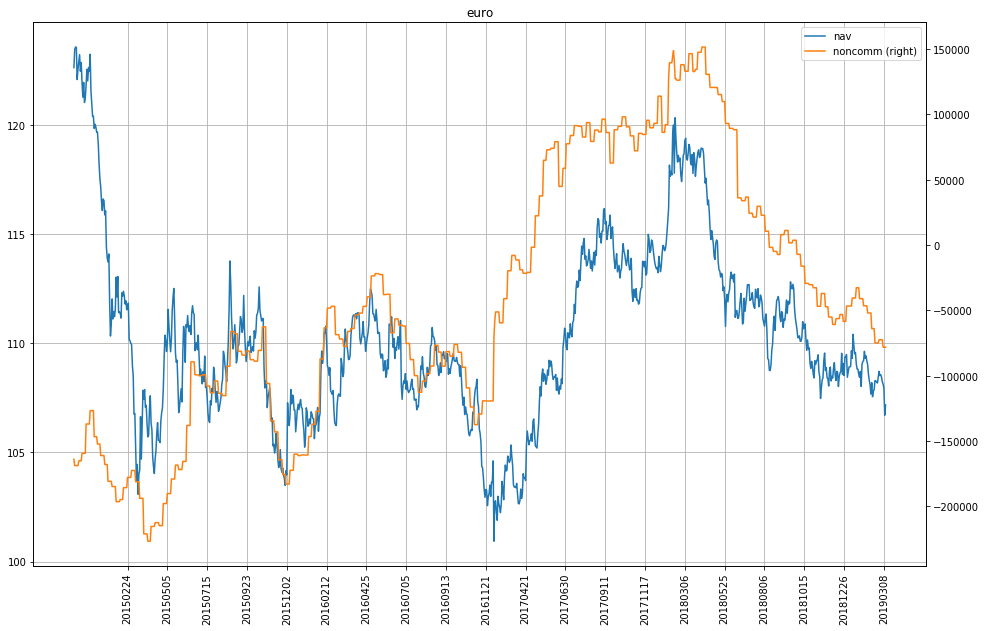

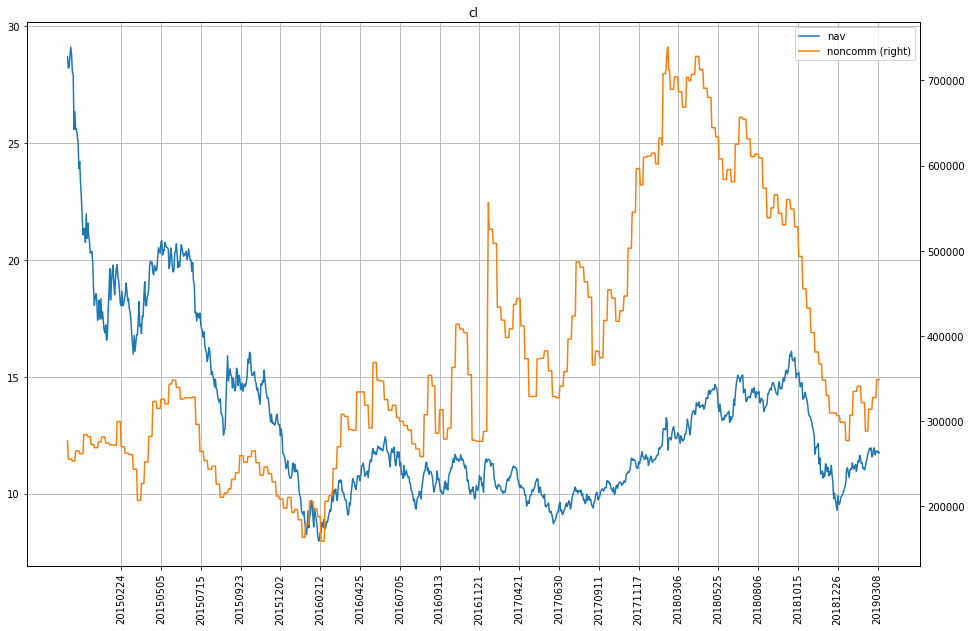

In [38]:
ju.multi_df_plot(dict_df=dict_df,x_column='trade_date',save_file_prefix='cot_nav_plot',save_image_folder='./temp_folder/saved_images')    


___
### The cells below help you find commodities in df_cot2 and df_oi
___

In [12]:
list(filter(lambda s: str(s)!='nan' and 'CRUDE OIL LIGHT SWEET FUTURES' in s and 'FUTURE' in s,list(set(df_oi.Product_Description))))

['CRUDE OIL LIGHT SWEET FUTURES']

In [13]:
list(filter(lambda s: str(s)!='nan' and 'CRUDE OIL, LIGHT SWEET - NEW YORK MERCANTILE EXCHANGE' in s ,list(set(df_cot2.Market_and_Exchange_Names))))

['E-MINY CRUDE OIL, LIGHT SWEET - NEW YORK MERCANTILE EXCHANGE',
 'CRUDE OIL, LIGHT SWEET - NEW YORK MERCANTILE EXCHANGE']

In [14]:
print(df_cot2[df_cot2.Market_and_Exchange_Names=='COTTON NO. 2 - NEW YORK COTTON EXCHANGE'].Open_Interest_All.sum())
print(df_cot2[df_cot2.Market_and_Exchange_Names=='COTTON NO. 2 - ICE FUTURES U.S.'].Open_Interest_All.sum())

18712555
115437439


In [15]:
list(filter(lambda s: 'Comm' in s,df_cot2.columns.values))

['%_of_OI_Commercial_Long_All',
 '%_of_OI_Commercial_Long_Old',
 '%_of_OI_Commercial_Long_Other',
 '%_of_OI_Commercial_Short_All',
 '%_of_OI_Commercial_Short_Old',
 '%_of_OI_Commercial_Short_Other',
 'CFTC_Commodity_Code',
 'CFTC_Commodity_Code_Quotes',
 'CFTC_Commodity_Code_Quotes_',
 'Change_in_Commercial_Long_All',
 'Change_in_Commercial_Short_All',
 'Commercial_Positions_Long_All',
 'Commercial_Positions_Long_Old',
 'Commercial_Positions_Long_Other',
 'Commercial_Positions_Short_All',
 'Commercial_Positions_Short_Old',
 'Commercial_Positions_Short_Other',
 'Traders_Commercial_Long_All',
 'Traders_Commercial_Long_Old',
 'Traders_Commercial_Long_Other',
 'Traders_Commercial_Short_All',
 'Traders_Commercial_Short_Old',
 'Traders_Commercial_Short_Other']

In [18]:
df_cot2_cl = df_cot2[df_cot2.Market_and_Exchange_Names=='CRUDE OIL, LIGHT SWEET - NEW YORK MERCANTILE EXCHANGE']
df_cot2_cl = df_cot2_cl[['As_of_Date_in_Form_YYMMDD','Commercial_Positions_Long_All']]
df_cot2_cl = df_cot2_cl.sort_values('As_of_Date_in_Form_YYMMDD')
df_cot2_cl.tail()

,As_of_Date_in_Form_YYMMDD,Commercial_Positions_Long_All
26160,190205,816098
26161,190212,841465
26162,190219,809084
26163,190226,822211
26164,190305,811089


In [25]:
fetch_history('WEAT',dt)

TypeError: fetch_history() missing 2 required positional arguments: 'dt_beg' and 'dt_end'

## END